# Intelligente Raumsteuerung: Anwesenheitserkennung durch Sensordaten

**Problem:** Energieverschwendung durch Heizen leerer Räume vs. Mitarbeiterkomfort.

**Ziel:** Ein Modell entwickeln, das Anwesenheit präzise vorhersagt, um Heizkosten zu senken, ohne dass jemand friert.

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split

## 1. Ein kurzer Blick auf Rohdaten

### 1.1. Datensatz laden

In [3]:
df_raw = pd.read_csv('Datensatz-Sensor.csv')

# df_test_raw = pd.read_csv('.csv')

In [4]:
df = df_raw.copy()
df['Datum'] = pd.to_datetime(df['Datum'], yearfirst=True)
df.set_index('Datum', inplace=True)

In [5]:
# df_test = df_test_raw.copy()
# df_test['Datum'] = pd.to_datetime(df_test['Datum'], yearfirst=True)
# df_test.set_index('Datum', inplace=True)

In [6]:
df.head()

,Temperatur,Feuchtigkeit,CO2,Wassergehalt,Anwesenheit
Datum,,,,,
2015-02-02 14:19:00,23.7000,26.272,749.200000,0.004764,1
2015-02-02 14:19:59,23.7180,26.290,760.400000,0.004773,1
2015-02-02 14:21:00,23.7300,26.230,769.666667,0.004765,1
2015-02-02 14:22:00,23.7225,26.125,774.750000,0.004744,1
2015-02-02 14:23:00,23.7540,26.200,779.000000,0.004767,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19236 entries, 2015-02-02 14:19:00 to 2015-02-17 11:15:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperatur    19134 non-null  float64
 1   Feuchtigkeit  18915 non-null  float64
 2   CO2           19236 non-null  float64
 3   Wassergehalt  18777 non-null  float64
 4   Anwesenheit   19236 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 901.7 KB


In [8]:
df.describe()

,Temperatur,Feuchtigkeit,CO2,Wassergehalt,Anwesenheit
count,19134.000000,18915.000000,19236.000000,18777.000000,19236.000000
mean,21.322743,27.451396,634.818354,0.004189,0.226606
std,3.908221,5.008853,260.246196,0.000759,0.418647
min,19.000000,16.745000,0.000000,0.002674,0.000000
25%,20.133333,24.290000,454.500000,0.003699,0.000000
50%,20.675000,27.171429,545.500000,0.004278,0.000000
75%,21.600000,31.050000,734.541667,0.004799,0.000000
max,55.998944,39.500000,2028.500000,0.006476,1.000000


### 1.2. Fehler in den Daten beheben

In [9]:
ideal_index = df.index.round('1min')
non_round_mask = df.index != ideal_index
print(f'Indexe zur Abrundung: {non_round_mask.sum()}')
df.index = ideal_index

Indexe zur Abrundung: 5986


In [10]:
# ideal_index_test = df_test.index.round('1min')
# non_round_mask_test = df_test.index != ideal_index_test
# df_test.index = ideal_index_test

Wir haben festgestellt, dass manche Temperaturwerte oberhalb 40 Grad Celsius liegen, was auf fehlerhafte Sensoren hinweist. Ebenso sind CO2-Werte unter ~400 ppm nicht realistisch.

Visualisierung der fehlerhaften Werte:

In [91]:
num_cols = ['Temperatur', 'Feuchtigkeit', 'CO2', 'Wassergehalt']
df_melted = df.melt(value_vars=num_cols, var_name='Sensor', value_name='Wert')

fig = px.box(
    df_melted, 
    y='Wert',            
    facet_col='Sensor',  
    facet_col_wrap=2,
    color='Sensor',     
    title='Boxplots der Sensorwerte'    
)

fig.update_yaxes(matches=None) 
fig.for_each_yaxis(lambda y: y.update(showticklabels=True))
fig.show(renderer = "browser")

Korrektur der fehlerhaften Werte:

In [12]:
mask_temp = df['Temperatur'] >= 40
mask_co2 = (df['CO2'] < 0) | np.isclose(df['CO2'], 0)

df.loc[mask_temp, 'Temperatur'] = np.nan
df.loc[mask_co2, 'CO2'] = np.nan

In [13]:
# mask_temp_test = df_test['Temperatur'] >= 40
# mask_co2_test = (df_test['CO2'] < 0) | np.isclose(df_test['CO2'], 0)

# df_test.loc[mask_temp_test, 'Temperatur'] = np.nan
# df_test.loc[mask_co2_test, 'CO2'] = np.nan

In [14]:
print(df.isna().sum())

Temperatur      359
Feuchtigkeit    321
CO2             195
Wassergehalt    459
Anwesenheit       0
dtype: int64


In [15]:
fig = px.box(
    df_melted, 
    y='Wert',            
    facet_col='Sensor',  
    facet_col_wrap=2,
    color='Sensor',     
    title='Boxplots der Sensorwerte'    
)

fig.update_yaxes(matches=None) 
fig.for_each_yaxis(lambda y: y.update(showticklabels=True))
fig.show(renderer = "browser")

Wir bilden alle Daten ab, um sie besser zu verstehen und mögliche Fehler zu identifizieren.

Die detaillierte Visualisierung des Zeitraums vom 11. bis 12. Februar zeigt, dass an diesem Tag aufgrund eines vermutlichen Sensorausfalls keine Messdaten vorliegen.

In [16]:
df_plot = df.reset_index() 

df_melted = df_plot.melt(
    id_vars='Datum', 
    value_vars=num_cols, 
    var_name='Sensor', 
    value_name='Wert'
)

fig = px.line(
    df_melted, 
    x='Datum', 
    y='Wert', 
    facet_row='Sensor',
    color = 'Sensor',  
    height=1000,         
    title="Zeitlicher Verlauf aller Sensoren"
)

fig.update_yaxes(matches=None) 

fig.show(renderer = "browser")

### 1.3. Neue Features aus Datum ableiten

1. Zunächst werden die Stunden extrahiert. Diese werden als String betrachtet, da das Modell die Zyklizität nicht erkennen kann.
2. Gleichweise werden die Wochentage extrahiert.
3. Aus Wochentagen wird eine binäre Markierung erstellt, die angibt, ob die Daten am Wochenende gemessen wurden.
4. Aus Stunden wird eine binäre Markierung erstellt, die angibt, ob die Daten während der Arbeitszeiten gemessen wurden.

In [17]:
is_working_time = (df.index.time > pd.to_datetime('07:30').time()) & (df.index.time < pd.to_datetime('18:30').time()) # Arbeitszeit von 07:30 bis 18:30
is_weekend = df.index.dayofweek.isin([5, 6]) # Samstag und Sonntag

df['Stunde'] = df.index.hour.astype(str) # Stunde als String
df['Kernzeit'] = is_working_time.astype(int)
df['Wochentag'] = df.index.day_name() # Wochentag als String
df['Ist_Wochenende'] = is_weekend.astype(int)

df

,Temperatur,Feuchtigkeit,CO2,Wassergehalt,Anwesenheit,Stunde,Kernzeit,Wochentag,Ist_Wochenende
Datum,,,,,,,,,
2015-02-02 14:19:00,23.7000,26.272,749.200000,0.004764,1,14,1,Monday,0
2015-02-02 14:20:00,23.7180,26.290,760.400000,0.004773,1,14,1,Monday,0
2015-02-02 14:21:00,23.7300,26.230,769.666667,0.004765,1,14,1,Monday,0
2015-02-02 14:22:00,23.7225,26.125,774.750000,0.004744,1,14,1,Monday,0
2015-02-02 14:23:00,23.7540,26.200,779.000000,0.004767,1,14,1,Monday,0
...,...,...,...,...,...,...,...,...,...
2015-02-17 11:11:00,21.3900,32.440,1069.750000,0.005115,1,11,1,Tuesday,0
2015-02-17 11:12:00,21.3900,32.345,1079.500000,0.005100,1,11,1,Tuesday,0
2015-02-17 11:13:00,21.3900,32.290,1076.000000,0.005092,1,11,1,Tuesday,0


In [18]:
# is_working_time_tet = (df_test.index.time > pd.to_datetime('07:30').time()) & (df_test.index.time < pd.to_datetime('18:30').time()) # Arbeitszeit von 07:30 bis 18:30
# is_weekend_test = df_test.index.dayofweek.isin([5, 6]) # Samstag und Sonntag

# df_test['Stunde'] = df_test.index.hour.astype(str) # Stunde als String
# df_test['Kernzeit'] = is_working_time_test.astype(int)
# df_test['Wochentag'] = df_test.index.day_name() # Wochentag als String
# df_test['Ist_Wochenende'] = is_weekend_test.astype(int)

### 1.4. Daten aufteilen und interpolieren

In [19]:
y = df.pop('Anwesenheit')
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42, shuffle=False)
X_train.head()

,Temperatur,Feuchtigkeit,CO2,Wassergehalt,Stunde,Kernzeit,Wochentag,Ist_Wochenende
Datum,,,,,,,,
2015-02-02 14:19:00,23.7000,26.272,749.200000,0.004764,14,1,Monday,0
2015-02-02 14:20:00,23.7180,26.290,760.400000,0.004773,14,1,Monday,0
2015-02-02 14:21:00,23.7300,26.230,769.666667,0.004765,14,1,Monday,0
2015-02-02 14:22:00,23.7225,26.125,774.750000,0.004744,14,1,Monday,0
2015-02-02 14:23:00,23.7540,26.200,779.000000,0.004767,14,1,Monday,0


In [20]:
# y_test = df_test.pop('Anwesenheit')
# X_test = df_test

Die Trainings- und Testdaten werden separat interpoliert. Dadurch wird Data Leakage vermieden.

In [21]:
X_train.interpolate(method='time', inplace=True) 
X_test.interpolate(method='time', inplace=True)

print(X_train.isna().sum())

Temperatur        0
Feuchtigkeit      0
CO2               0
Wassergehalt      0
Stunde            0
Kernzeit          0
Wochentag         0
Ist_Wochenende    0
dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_34996\896599330.py:1: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

C:\Users\user\AppData\Local\Temp\ipykernel_34996\896599330.py:2: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



## 2. Feature Engineering

### 2.1. EDA

Diese Grafiken stellen die numerischen Sensorwerte (Temperatur, Feuchtigkeit, CO2, Wassergehalt) paarweise gegeneinander dar. Die Einfärbung visualisiert die Zielvariable ("Anwesenheit" und "Nicht-Anwesenheit").

Die blauen Punkte ("Anwesenheit") sammeln sich deutlich in Bereichen mit hohen CO2-Werten und höherer Temperatur. Dies bestätigt, dass diese Sensorwerte starke Indikatoren für menschliche Präsenz sind.

In [22]:
fig = px.scatter_matrix(X_train, 
                dimensions=num_cols,
                color=y_train,
                color_discrete_map={
                    0: 'red',
                    1: 'blue'
                },
                width=900,
                height=900, 
                )

fig.update_layout(coloraxis_showscale=False)

fig.show(renderer="browser")

Die Boxplots zeigen die Verteilung der Sensorwerte in Abhängigkeit von der Anwesenheit. Bei Anwesenheit (1) liegen die Boxen für CO2 und Temperatur sichtbar höher als bei Abwesenheit.

In [23]:
df_plot = X_train.copy()
df_plot['Anwesenheit'] = y_train

df_melted = df_plot.melt(id_vars='Anwesenheit', value_vars=num_cols, var_name='Sensor', value_name='Wert')

fig = px.box(
    df_melted, 
    x="Anwesenheit", 
    y="Wert", 
    color="Anwesenheit", 
    facet_col="Sensor",       
    facet_col_wrap=2,         
    title="Verteilung der Sensorwerte nach Anwesenheit",
    color_discrete_map={0: 'red',1: 'blue'}
)


fig.update_yaxes(matches=None) 
fig.for_each_yaxis(lambda y: y.update(showticklabels=True))
fig.show(renderer = "browser")

### 2.2. Zusätzliche Features erstellen & One Hot Encoding durchführen

In [24]:
X_train['Temperatur^2'] = X_train['Temperatur'] ** 2 # Quadratischer Term der Temperatur
X_train['Feuchtigkeit^2'] = X_train['Feuchtigkeit'] ** 2 # Quadratischer Term der Feuchtigkeit
X_train['CO2_diff'] = X_train['CO2'].diff(5) # 5-Minuten-Differenz (CO2 jetzt minus CO2 vor 5 Minuten)

X_test['Temperatur^2'] = X_test['Temperatur'] ** 2
X_test['Feuchtigkeit^2'] = X_test['Feuchtigkeit'] ** 2
X_test['CO2_diff'] = X_test['CO2'].diff(5)

One Hot Encoding für Stunden und Wochentage wurde durchgeführt.

In [25]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="if_binary")

one_hot_columns_train = pd.DataFrame(enc.fit_transform(X_train[['Stunde', 'Wochentag']]))
one_hot_columns_train.columns = enc.get_feature_names_out()
one_hot_columns_train.index = X_train.index

one_hot_columns_test = pd.DataFrame(enc.transform(X_test[['Stunde', 'Wochentag']]))
one_hot_columns_test.columns = enc.get_feature_names_out()
one_hot_columns_test.index = X_test.index

In [26]:
X_train = pd.concat([X_train, one_hot_columns_train], axis=1)
X_train.drop(columns=['Stunde', 'Wochentag'], inplace=True)

X_test = pd.concat([X_test, one_hot_columns_test], axis=1)
X_test.drop(columns=['Stunde', 'Wochentag'], inplace=True)

## 3. Modelltraining

In diesem Kapitel entwickeln und evaluieren wir verschiedene Klassifikationsmodelle, um die Anwesenheit von Personen basierend auf den Sensordaten vorherzusagen. Unser Ziel ist es, ein Modell zu finden, das eine hohe Vorhersagegenauigkeit hat.

### 3.1. Logistic Regression

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

#### 3.1.1. GridSearchCV, Suche nach besten Hyperparameter

Definition der Pipeline für die Logistische Regression: 
1. SimpleImputer: Behandelt fehlende Werte (NaN), indem sie durch den Mittelwert ersetzt werden.
2. StandardScaler: Bringt alle Features auf eine einheitliche Skala. Dies ist für die Logistische Regression wichtig, damit Features mit großen Zahlenwerten das Modell nicht dominieren.
3. LogisticRegression: Unseres Klassifikationsmodell.

In [28]:
pipe_logreg = Pipeline([
    ('imputer', SimpleImputer()), # Erste 5 fehlende Werte durch Mittelwert ersetzen
    ('scaler', StandardScaler()), # Merkmale skalieren
    ('logreg', LogisticRegression(  
        max_iter=2000, 
        random_state=42 
    ))
])

Wir ermitteln die optimale Konfiguration für die Logistische Regression mittels GridSearchCV. Dabei testen wir verschiedene Werte für den Regularisierungsparameter C sowie die Art der Regularisierung (L1 oder L2).

In [29]:
param_grid_logreg = [
    {
        'logreg__penalty': ['l1'], # L1-Regularisierung
        'logreg__solver': ['liblinear', 'saga'], # Nur diese Solver unterstützen L1
        'logreg__C': [0.01, 0.1, 1, 10, 100],
        'logreg__class_weight': [None, 'balanced'],
    },
    {
        'logreg__penalty': ['l2'], # L2-Regularisierung
        'logreg__solver': ['lbfgs', 'liblinear', 'saga'], # Diese Solver unterstützen L2
        'logreg__C': [0.01, 0.1, 1, 10, 100],
        'logreg__class_weight': [None, 'balanced'],
    },
]


Unsere Vorgehensweise : 
1. cv=TimeSeriesSplit(): Wir nutzen erneut die zeitbasierte Kreuzvalidierung, um Overfitting zu vermeiden und die Zeitstruktur zu beizubehalten.

2. scoring='f1': Da unsere Daten unbalanciert sind (der Raum ist öfter leer als belegt), verwenden wir den F1-Score. Dieser stellt sicher, dass das Modell die seltene Klasse ("Anwesend") zuverlässig erkennt und nicht lediglich die Mehrheitsklasse ("Abwesend") vorhersagt.

3. n_jobs=-1: Wir nutzen alle verfügbaren Prozessorkerne, um die Berechnung zu beschleunigen.

In [30]:
grid_logreg  = GridSearchCV(
    pipe_logreg,
    param_grid_logreg,
    scoring='f1', # Standardmäßig: accuracy
    cv=TimeSeriesSplit(),
    n_jobs=-1 # Parallelisierung
)

grid_logreg.fit(X_train, y_train)

best_model_logreg = grid_logreg.best_estimator_ # Bestes Modell nach Grid Search

print("Beste Parameter: ", grid_logreg.best_params_)

Beste Parameter:  {'logreg__C': 100, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


#### 3.1.2. Feature Importance

Wir möchten analysieren, welche Features den größten Einfluss auf den F1-Score haben. Die Methode permutation_importance permutiert (mischt) die Werte einer einzelnen Spalte zufällig, während alle anderen Spalten unverändert bleiben. Anschließend wird gemessen, wie stark der F1-Score dadurch sinkt.

In [31]:
importances = permutation_importance(
    best_model_logreg,
    X_train,
    y_train,
    n_repeats=30,
    random_state=42,
    n_jobs=-1,
    scoring='f1'
)

perm_df_logreg = pd.DataFrame({
    'feature' : X_train.columns,
    'importance_mean' : abs(importances.importances_mean)
}).sort_values(by='importance_mean', ascending=False)

perm_df_logreg

,feature,importance_mean
0,Temperatur,0.567653
3,Wassergehalt,0.543493
4,Kernzeit,0.529113
1,Feuchtigkeit,0.394242
6,Temperatur^2,0.193417
5,Ist_Wochenende,0.092016
35,Wochentag_Saturday,0.075743
36,Wochentag_Sunday,0.029921
19,Stunde_18,0.015959
30,Stunde_7,0.008833


Die Tabelle zeigt die Top-Features:

1. Kernzeit (0.26)

2. CO2 (0.10)

3. Ist_Wochenende (0.06)

4. Wochentag_Friday (0.04)

In [32]:
px.histogram(perm_df_logreg, x='feature', y='importance_mean', title='Feature Importances (Logistische Regression)', log_y=True).show(renderer="browser")

Wir haben festgestellt, dass viele Features einen geringen Einfluss auf die Vorhersage haben. Wir trainieren  ein neues Modell, das nur die Top 15 wichtigsten Merkmale verwendet.

In [33]:
X_train_reduced_logreg = X_train[perm_df_logreg.head(15)['feature'].values] # Nur die 15 wichtigsten Merkmale

grid_logreg_2  = GridSearchCV(
    pipe_logreg,
    param_grid_logreg,
    scoring='f1',
    cv=TimeSeriesSplit(),
    n_jobs=-1
)

grid_logreg_2.fit(X_train_reduced_logreg, y_train)

best_model_logreg_2 = grid_logreg_2.best_estimator_

print("Beste Parameter: ", grid_logreg_2.best_params_)

Beste Parameter:  {'logreg__C': 0.01, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}


### 3.2. Decision Tree

Für einen Entscheidungsbaum werden die gleichen Features benutzt. Ausnamen sind 'Stunde' und 'Wochentag', die nun als Zahlen betrachtet werden. Damit wird sichergestellt, dass der Entscheidungsbaum nicht zu tief wird, was mit One Hot Encoding für Stunden und Wochentage sicherlich der Fall wäre.

In [34]:
X_train_tree = X_train[['Temperatur', 'Feuchtigkeit', 'CO2', 'Wassergehalt', 'Temperatur^2','Feuchtigkeit^2' ,'CO2_diff', 'Kernzeit', 'Ist_Wochenende']].copy()
X_test_tree = X_test[['Temperatur', 'Feuchtigkeit', 'CO2', 'Wassergehalt', 'Temperatur^2','Feuchtigkeit^2', 'CO2_diff', 'Kernzeit', 'Ist_Wochenende']].copy()

X_train_tree['Stunde'] = X_train_tree.index.hour # Jetzt als Zahl
X_train_tree['Wochentag'] = X_train_tree.index.dayofweek # Wochentag als Zahl

X_test_tree['Stunde'] = X_test_tree.index.hour
X_test_tree['Wochentag'] = X_test_tree.index.dayofweek

Vorgehensweise: 
1. Definition der Pipeline mit SimpleImputer und DecisionTreeClassifier.
2. Suche nach den besten Hyperparametern.
3. Verwendung von GridSearchCV, um die optimale Balance der Parameter zu finden und das Modell zu optimieren.

In [35]:
pipe_tree = Pipeline([
    ('imputer', SimpleImputer()),
    ('tree', DecisionTreeClassifier(random_state=42))
])

param_grid_tree = { # Hyperparameter für Entscheidungsbaum
    'tree__max_depth': [3, 5, 8, 12, 15, 30, None],
    'tree__min_samples_leaf': [1, 5, 10, 20],
    'tree__min_samples_split': [2, 10, 20, 50],
    'tree__max_features': [None, 'sqrt', 'log2'],
    'tree__class_weight': [None, 'balanced']
}

grid_tree = GridSearchCV( # Grid Search für Entscheidungsbaum
    pipe_tree,
    param_grid_tree,
    cv=TimeSeriesSplit(), # Zeitreihen-Cross-Validation
    scoring='f1', # Standardmäßig: accuracy
    n_jobs=-1
)

grid_tree.fit(X_train_tree, y_train)

best_model_tree = grid_tree.best_estimator_

grid_tree.best_params_

{'tree__class_weight': 'balanced',
 'tree__max_depth': 5,
 'tree__max_features': 'sqrt',
 'tree__min_samples_leaf': 20,
 'tree__min_samples_split': 2}

Visualisierung des Entscheidungsbaums:

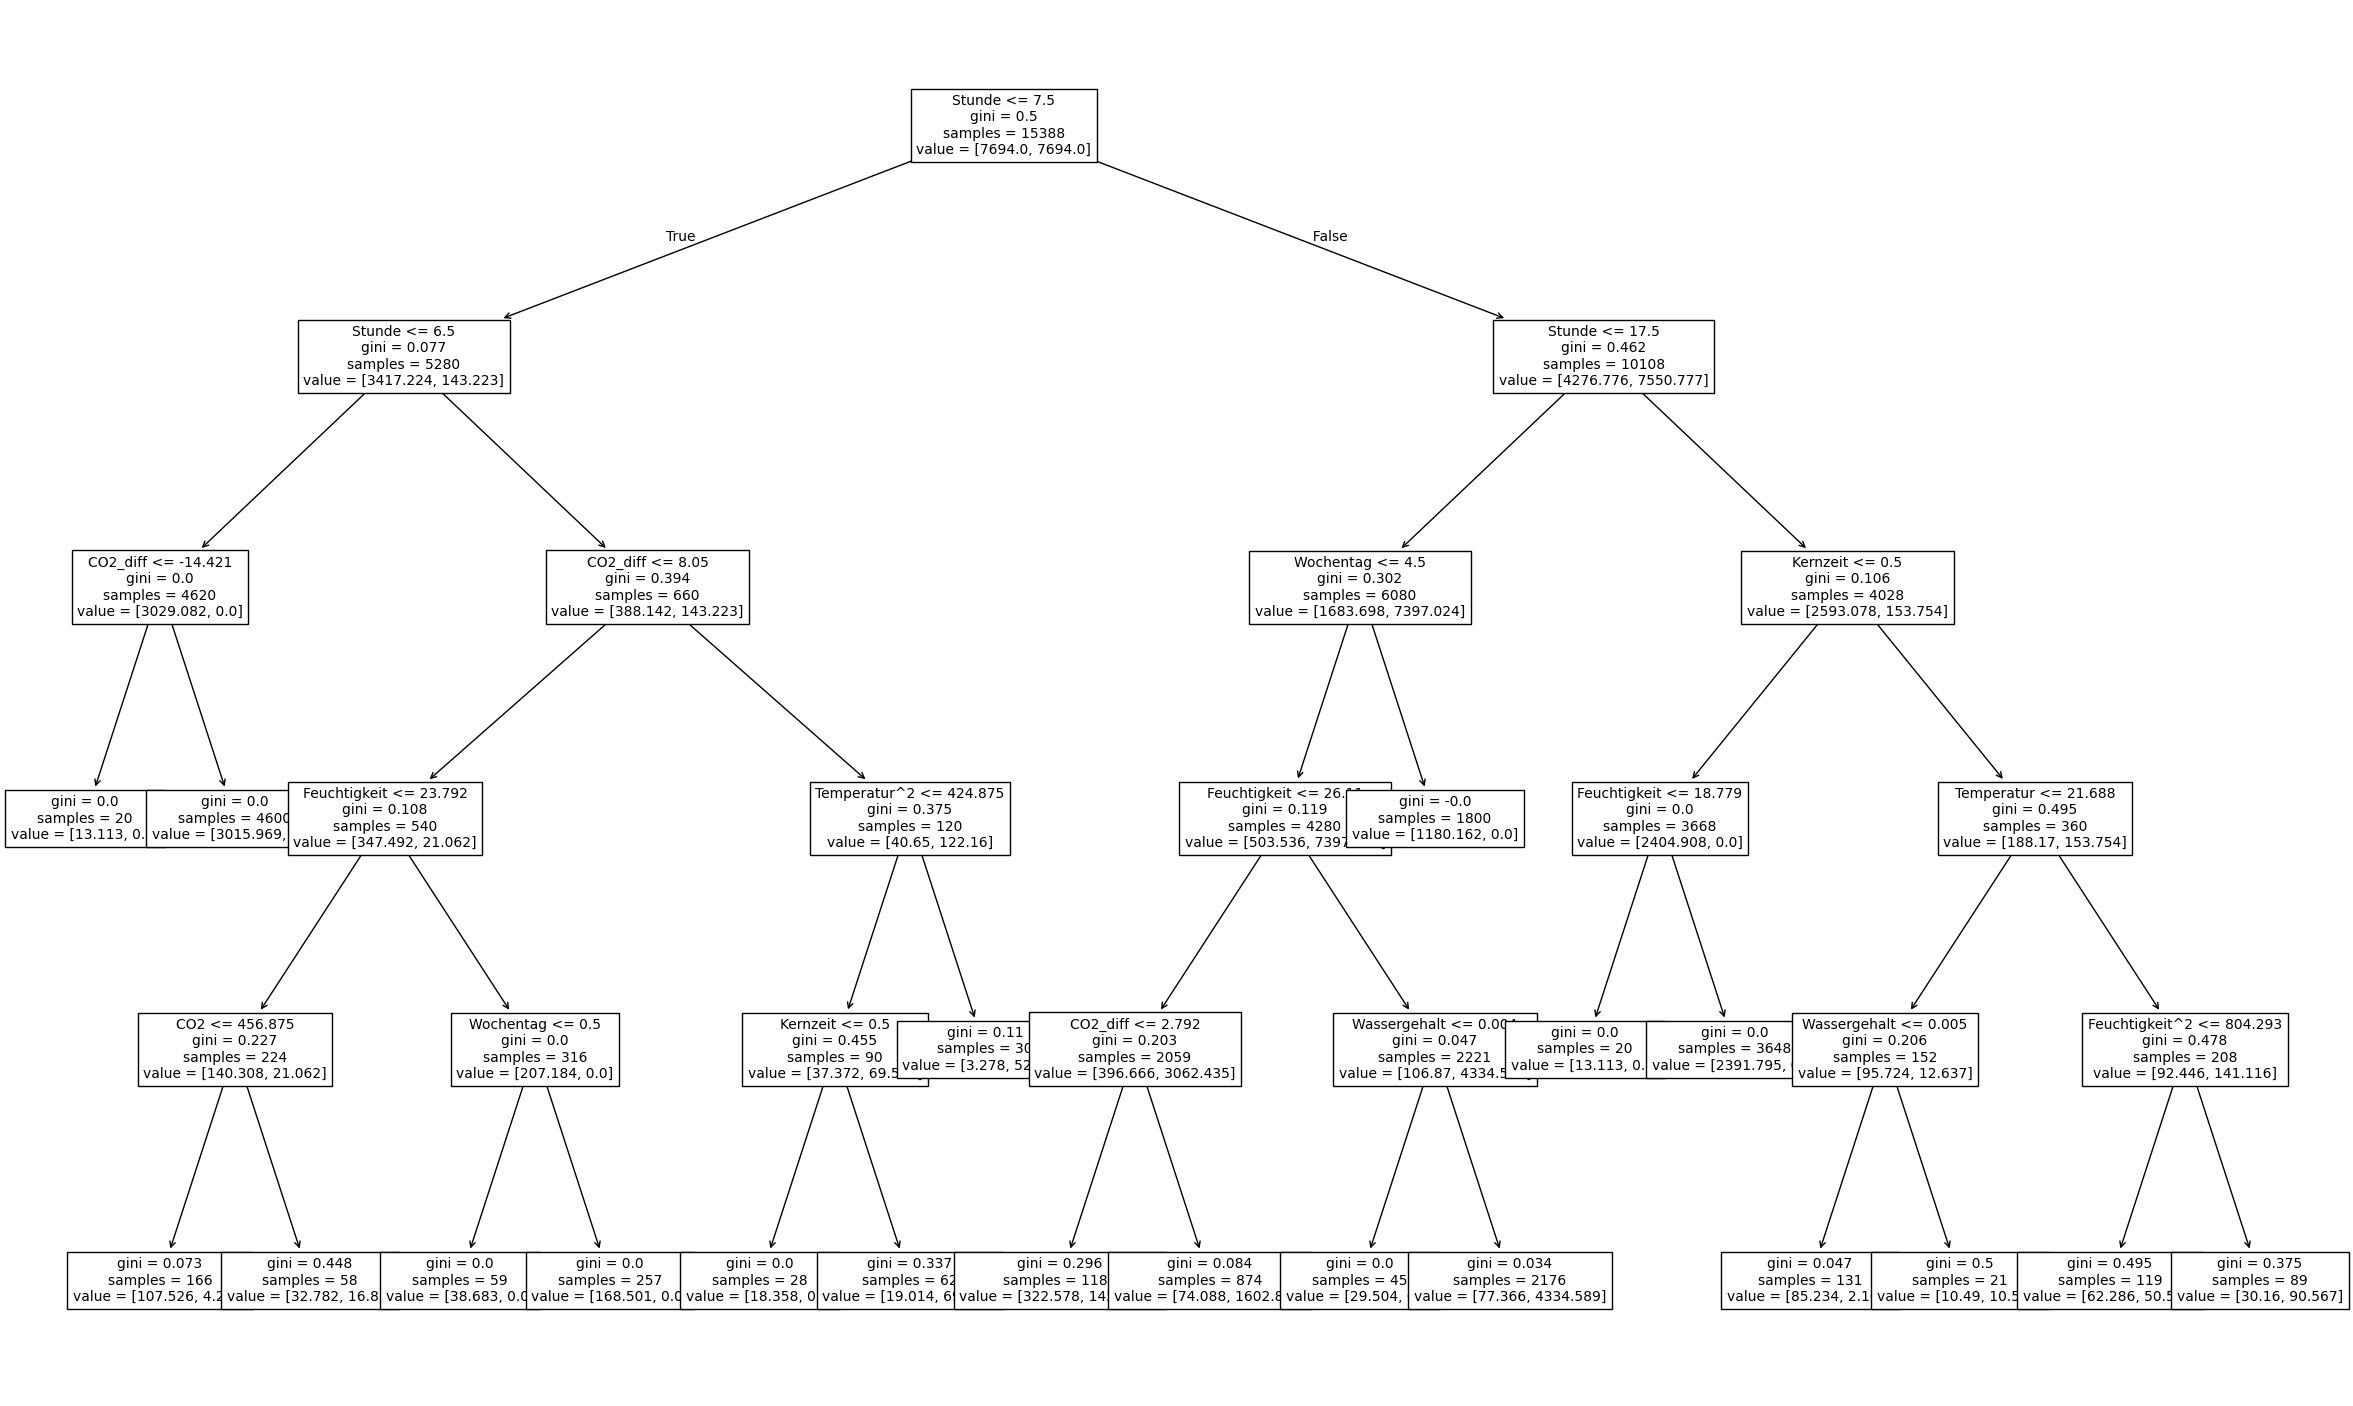

In [36]:
plt.figure(figsize=(30,18))
_ = plot_tree(best_model_tree['tree'], feature_names=X_train_tree.columns, fontsize=10) # Entscheidungsbaum mit besten Hyperparametern visualisieren
plt.show()

### 3.3. Random Forest

Wir trainieren zwei Varianten des Random Forest, um den Einfluss der Datenaufbereitung zu testen:

1. **Variante A** (Mit One-Hot-Encoding): Wir nutzen den Datensatz X_train, bei dem Stunden und Wochentage One-Hot-codiert sind.

2. **Variante B** (Ohne One-Hot-Encoding): Wir nutzen den Datensatz X_train_tree, bei dem Stunden und Wochentage numerisch (als Integer) vorliegen.

Pipline Definition:
1. SimpleImputer: Behandelt fehlende Werte (NaN), indem sie durch den Mittelwert ersetzt werden.
2. RandomForestClassifier: Unser Klassifikationsmodell.

In [37]:
pipe_rf = Pipeline([
    ('imputer', SimpleImputer()),
    ('rf', RandomForestClassifier(
        n_jobs=-1,
        random_state=42
    ))
])

Im param_grid_rf definieren wir den Suchraum für das Parameter-Tuning mittels GridSearchCV, um die besten Hyperparameter für den Random Forest zu ermitteln.

In [38]:
param_grid_rf = { 
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 5, 10, 20],
    'rf__min_samples_leaf': [1, 5, 10],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__class_weight': [None, 'balanced']
}

#### 3.3.1. Mit Ohe Hot Encoding

In [39]:
# mit default X_Train und y_train wie bei LogReg

grid_rf = GridSearchCV( # Grid Search für Random Forest
    pipe_rf,
    param_grid_rf,
    cv=TimeSeriesSplit(), # Zeitreihen-Cross-Validation
    scoring='f1', # Standardmäßig: accuracy
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print(f'params: {grid_rf.best_params_}')

best_model_rf_mit_ohe = grid_rf.best_estimator_

params: {'rf__class_weight': None, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 5, 'rf__n_estimators': 200}


Die beste Konfiguration für den Random Forest mit One-Hot-Encoding wurde wie folgt identifiziert:

In [40]:
importances_rf_mit_ohe = permutation_importance(
    best_model_rf_mit_ohe,
    X_train,
    y_train,
    n_repeats=30,
    random_state=42,
    n_jobs=-1,
    scoring='f1'
)

perm_df_rf_mit_ohe = pd.DataFrame({
    'feature' : X_train.columns,
    'importance_mean' : abs(importances_rf_mit_ohe.importances_mean)
}).sort_values(by='importance_mean', ascending=False)

perm_df_rf_mit_ohe

,feature,importance_mean
4,Kernzeit,0.325549
2,CO2,0.067329
8,CO2_diff,0.027449
0,Temperatur,0.018708
6,Temperatur^2,0.009920
31,Stunde_8,0.006553
37,Wochentag_Thursday,0.004895
32,Stunde_9,0.004573
7,Feuchtigkeit^2,0.003551
19,Stunde_18,0.003353


Die wichtigsten Merkmale für den Random Forest mit One-Hot-Encoding sind: 
1. Kernzeit (0.24)
2. CO2 (0.14)
3. CO2_diff	(0.016)

In [41]:
px.histogram(perm_df_rf_mit_ohe, x='feature', y='importance_mean', title='Feature Importances (Random Forest) MIT OHE', log_y=True).show(renderer="browser")

Basierend auf der Permutation Importance haben wir festgestellt, dass nicht alle One-Hot-Encoded Features gleichermaßen relevant sind. In diesem Schritt reduzieren wir den Datensatz auf die 15 wichtigsten Merkmale.

In [42]:
X_train_reduced_rf = X_train[perm_df_rf_mit_ohe.head(15)['feature'].values] # Top 15 Merkmale auswählen

grid_rf_2 = GridSearchCV( # Grid Search für Random Forest
    pipe_rf,
    param_grid_rf,
    cv=TimeSeriesSplit(), # Zeitreihen-Cross-Validation
    scoring='f1', # Standardmäßig: accuracy
    n_jobs=-1
)

grid_rf_2.fit(X_train_reduced_rf, y_train)

best_model_rf_2_mit_ohe = grid_rf_2.best_estimator_

print("Beste Parameter: ", grid_rf_2.best_params_)

Beste Parameter:  {'rf__class_weight': 'balanced', 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__n_estimators': 200}


#### 3.2.2. Ohne One Hot Encoding

In [43]:
# mit X_train TREE und y_train TREE
# wir löschen keine Features, da es nur 10 Features gibt

grid_rf = GridSearchCV( # Grid Search für Random Forest
    pipe_rf,
    param_grid_rf,
    cv=TimeSeriesSplit(), # Zeitreihen-Cross-Validation
    scoring='f1', # Standardmäßig: accuracy
    n_jobs=-1
)

grid_rf.fit(X_train_tree, y_train)

print(f'params: {grid_rf.best_params_}')

best_model_rf_ohne_ohe = grid_rf.best_estimator_

params: {'rf__class_weight': None, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 10, 'rf__n_estimators': 200}


Die beste Konfiguration für den Random Forest ohne One-Hot-Encoding wurde wie folgt identifiziert:

In [44]:
importances_rf_ohne_ohe = permutation_importance(
    best_model_rf_ohne_ohe,
    X_train_tree,
    y_train,
    n_repeats=30,
    random_state=42,
    n_jobs=-1,
    scoring='f1'
)

perm_df_rf_ohne_ohe = pd.DataFrame({
    'feature' : X_train_tree.columns,
    'importance_mean' : abs(importances_rf_ohne_ohe.importances_mean)
}).sort_values(by='importance_mean', ascending=False)

perm_df_rf_ohne_ohe

,feature,importance_mean
7,Kernzeit,0.357996
2,CO2,0.169248
9,Stunde,0.066949
4,Temperatur^2,0.024727
0,Temperatur,0.023592
6,CO2_diff,0.022212
5,Feuchtigkeit^2,0.019437
1,Feuchtigkeit,0.015638
3,Wassergehalt,0.006912
10,Wochentag,0.003554


Die wichtigsten Features sind: 
1. Kernzeit (0.36)
2. CO2 (0.18)
3. Stunde (0.08)

In [45]:
px.histogram(perm_df_rf_ohne_ohe, x='feature', y='importance_mean', title='Feature Importances (Random Forest) OHNE OHE', log_y=True).show(renderer = "browser")

## 4. ROC-Kurven

Wir vergleichen die Performance aller trainierten Modelle (Logistische Regression, Entscheidungsbaum, Random Forest) in einer einzigen Grafik. Da die reine Genauigkeit (Accuracy) bei unbalancierten Daten irreführend sein kann, nutzen wir die ROC-Kurve.

In [46]:
from sklearn.metrics import roc_curve, auc

### 4.1. Logistic Regression

In [47]:
X_test_reduced_logreg = X_test[perm_df_logreg.head(15)['feature'].values] # Dieser Trainingsdatensatz wird für logistischen Regression mit Top 15 Merkmale benötigt

In [48]:
y_proba_logreg = best_model_logreg.predict_proba(X_test) # Wahrscheinlichkeiten für logistische Regression

y_pred_proba_logreg = y_proba_logreg[:, 1]
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_pred_proba_logreg) 
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

In [49]:
y_proba_logreg_2 = best_model_logreg_2.predict_proba(X_test_reduced_logreg) # Wahrscheinlichkeiten für reduzierten logistischen Regression

y_pred_proba_logreg_2 = y_proba_logreg_2[:, 1]
fpr_logreg_2, tpr_logreg_2, thresholds_logreg_2 = roc_curve(y_test, y_pred_proba_logreg_2) 
roc_auc_logreg_2 = auc(fpr_logreg_2, tpr_logreg_2)

#### 4.2. Desicion Tree

In [50]:
y_proba_tree = best_model_tree.predict_proba(X_test_tree)

y_pred_proba_tree = y_proba_tree[:, 1]
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_pred_proba_tree) 
roc_auc_tree = auc(fpr_tree, tpr_tree)

### 4.3. Random Forest

In [51]:
X_test_reduced_rf = X_test[perm_df_rf_mit_ohe.head(15)['feature'].values] # Dieser Trainingsdatensatz wird für Random Forest mit OHE und Top 15 Merkmalen benötigt

In [52]:
y_proba_rf_mit_ohe = best_model_rf_mit_ohe.predict_proba(X_test) # Wahrscheinlichkeiten für Random Forest mit OHE

y_pred_proba_rf_mit_ohe = y_proba_rf_mit_ohe[:, 1]
fpr_rf_mit_ohe, tpr_rf_mit_ohe, thresholds_rf_mit_ohe = roc_curve(y_test, y_pred_proba_rf_mit_ohe) 
roc_auc_rf_mit_ohe = auc(fpr_rf_mit_ohe, tpr_rf_mit_ohe)

In [53]:
y_proba_rf_mit_ohe_2 = best_model_rf_2_mit_ohe.predict_proba(X_test_reduced_rf) # Wahrscheinlichkeiten für Random Forest mit OHE und Top 15 Merkmale

y_pred_proba_rf_mit_ohe_2 = y_proba_rf_mit_ohe_2[:, 1]
fpr_rf_mit_ohe_2, tpr_rf_mit_ohe_2, thresholds_rf_mit_ohe_2 = roc_curve(y_test, y_pred_proba_rf_mit_ohe_2) 
roc_auc_rf_mit_ohe_2 = auc(fpr_rf_mit_ohe_2, tpr_rf_mit_ohe_2)

In [54]:
y_proba_rf_ohne_ohe = best_model_rf_ohne_ohe.predict_proba(X_test_tree) # Wahrscheinlichkeiten für Random Forest ohne OHE

y_pred_proba_rf_ohne_ohe = y_proba_rf_ohne_ohe[:, 1]
fpr_rf_ohne_ohe, tpr_rf_ohne_ohe, thresholds_rf_ohne_ohe = roc_curve(y_test, y_pred_proba_rf_ohne_ohe) 
roc_auc_rf_ohne_ohe = auc(fpr_rf_ohne_ohe, tpr_rf_ohne_ohe)

### 4.4. Vergleich

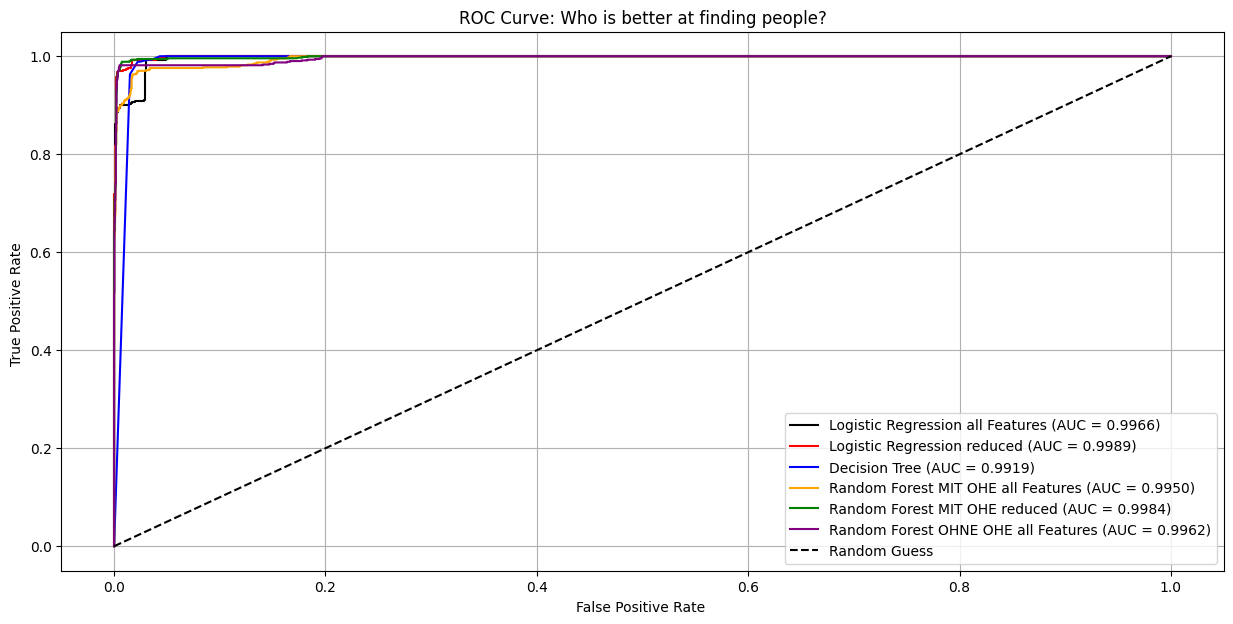

In [55]:
plt.figure(figsize=(15, 7))
plt.plot(fpr_logreg, tpr_logreg, color='black', label=f'Logistic Regression all Features (AUC = {roc_auc_logreg:.4f})')
plt.plot(fpr_logreg_2, tpr_logreg_2, color='red', label=f'Logistic Regression reduced (AUC = {roc_auc_logreg_2:.4f})')
plt.plot(fpr_tree, tpr_tree, color='blue', label=f'Decision Tree (AUC = {roc_auc_tree:.4f})')
plt.plot(fpr_rf_mit_ohe, tpr_rf_mit_ohe, color='orange', label=f'Random Forest MIT OHE all Features (AUC = {roc_auc_rf_mit_ohe:.4f})')
plt.plot(fpr_rf_mit_ohe_2, tpr_rf_mit_ohe_2, color='green', label=f'Random Forest MIT OHE reduced (AUC = {roc_auc_rf_mit_ohe_2:.4f})')
plt.plot(fpr_rf_ohne_ohe, tpr_rf_ohne_ohe, color='purple', label=f'Random Forest OHNE OHE all Features (AUC = {roc_auc_rf_ohne_ohe:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve: Who is better at finding people?')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate ')
plt.legend()
plt.grid()
plt.show()

Der Logistische Regression (all Features) zeigt die beste Performance mit einem AUC von 0.9966, gefolgt vom Randomforest und der Decision Tree.

## 5. Evaluation

In unserem Szenario stehen Precision und Recall in einem Zielkonflikt:

**Ziel 1:** Komfort (Niemand friert) Wir wollen alle anwesenden Personen erkennen.

*Benötigte Metrik:* Recall (Sensitivität) für Klasse 1 (Anwesend).

Ein hoher Recall weist auf wenige False Negatives hin (also geringe Zeit, in der gefroren wird).

*Konsequenz:* Die Heizung läuft möglicherweise häufiger, auch wenn niemand im Raum ist.

**Ziel 2:** Energie sparen (Niedrige Kosten) Wir wollen sicherstellen, dass die Heizung nur läuft, wenn wirklich jemand im Raum ist.

*Benötigte Metrik:* Precision für Klasse 1.

Eine hohe Precision bedeutet wenige False Positives (weniger Energieverschwendung).

*Konsequenz:* Die Heizung könnte manchmal abgeschaltet bleiben, obwohl sich jemand im Raum befindet.

In [56]:
from sklearn.metrics import confusion_matrix

### 5.1. Vorbereitung

In [57]:
def berechne_business_metrics(y_true, y_pred_model, model_name, anzahl_tage, minuten_pro_sample:int = 1):
    """"
    Berechnet und druckt die Kosten und Frierzeiten für ein gegebenes Modell.
    """

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_model).ravel()
    
    # 1. Kosten: Jede Minute, die die Heizung an ist (Vorhersage 1) kostet ca. 0.083 €
    heiz_minuten = (tp + fp) * minuten_pro_sample # Gesamtanzahl der Minuten, in denen die Heizung an ist
    kosten = heiz_minuten * (5 / 60) # Heizkosten in Euro
    
    # 2. Komfort: Minuten, die jemand friert (Vorhersage 0, aber eigentlich anwesend)
    frier_minuten_gesamt = fn * minuten_pro_sample # Gesamtanzahl der Minuten, in denen jemand friert
    frier_minuten_proTag = frier_minuten_gesamt / anzahl_tage # Durchschnittliche Anzahl der Minuten pro Tag, in denen jemand friert
    
    unnoetig_heiz_minuten = fp * minuten_pro_sample # Gesamtanzahl der Minuten, in denen unnötig geheizt wurde
    unnoetig_heiz_minuten_pro_tag = unnoetig_heiz_minuten / anzahl_tage # Durchschnittliche Anzahl der Minuten pro Tag, in denen unnötig geheizt wurde
    unnoetig_heiz_kosten = unnoetig_heiz_minuten * (5 / 60) # Kosten für unnötiges Heizen in Euro

    print(f"\n\t ** {model_name} **")
    print(f"Gesamtkosten (Heizung an): {kosten:.2f} €")
    print(f"\n Frier-Zeit (FN): "
          f"\n \t Gesamt: \t {frier_minuten_gesamt:.2f} Minuten"
          f"\n \t Pro Tag: \t {frier_minuten_proTag:.2f} Minuten")
    
    print(f"\n Unnötig geheizt (FP):" 
          f"\n \t Gesamt: \t {unnoetig_heiz_minuten} Minuten"
          f"\n \t Pro Tag: \t {unnoetig_heiz_minuten_pro_tag:.2f} Minuten"
          f"\n \t Unnötige Heiz-Kosten: \t {unnoetig_heiz_kosten:.2f} €")
    print("-" * 60)

In [58]:
anzahl_tage = len(X_test.index) / (24*60)
anzahl_tage # Anzahl der Tage im Testdatensatz

2.672222222222222

In [59]:
def best_threshold(model, X_train, y_train):
    """
    Bestimmt den besten Schwellenwert für die Klassifikation basierend auf dem F1-Score.
    """

    y_proba = model.predict_proba(X_train)[:, 1] # Wahrscheinlichkeiten für die positive Klasse

    thresholds = np.linspace(0.1, 0.99, 10) # Verschiedene Schwellenwerte testen
    f1_scores = [] # F1-Scores für jeden Schwellenwert speichern

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int) # Vorhersagen basierend auf dem Schwellenwert
        f1_scores.append(f1_score(y_train, y_pred)) # F1-Score berechnen
    
    print(f"Best threshold: {thresholds[np.argmax(f1_scores)]:.3f}")
    print(f"Best F1: {max(f1_scores):.3f}")

    return thresholds[np.argmax(f1_scores)], max(f1_scores) # Rückgabe des besten Schwellenwerts und des zugehörigen F1-Scores


In [60]:
def y_pred(model, X, threshold:float = 0.5):
    """
    Generiert Vorhersagen eines gegebenen Modells basierend auf einem gegebenen Schwellenwert.
    """

    return (model.predict_proba(X)[:, 1] >= threshold).astype(float)

In [61]:
def report(model, X_train, X_test, y_train, y_test, model_name, threshold:float=0.5):
    """
    Erstellt und druckt einen Bericht mit den wichtigsten Metriken für das gegebene Modell.
    """
    
    y_pred_train = y_pred(model, X_train, threshold) # Vorhersagen für Trainingsdaten
    y_pred_test = y_pred(model, X_test, threshold) # Vorhersagen für Testdaten

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    print(f'\n ** {model_name} **')
    print("-"*70)

    print(f'\nAccuracy Training-Set: {accuracy_train:.3f}')
    report_train = classification_report(y_train, y_pred_train)
    print("\nClassification Report Training-Set:\n", report_train)
    print('Confusion Matrix:')
    print(confusion_matrix(y_train, y_pred_train))
    print("-"*60)

    print(f'\nAccuracy Test-Set: {accuracy_test:.3f}')
    report_test = classification_report(y_test, y_pred_test)
    print("\nClassification Report Test-Set:\n", report_test)
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred_test))

### 5.2. Logistic Regression

In [62]:
X_test_reduced_logreg = X_test[perm_df_logreg.head(15)['feature'].values] # Dieser Testdatensatz wird für logistischen Regression mit Top 15 Merkmale benötigt

#### 5.2.1. Suche nach optimalem Schwellenwert für beide Modelle

In [63]:
# Schwellenwert für logistische Regression bestimmen
best_threshold_logreg, f1_scores_logreg = best_threshold(best_model_logreg, X_train, y_train)

Best threshold: 0.693
Best F1: 0.929


In [64]:
# Schwellenwert für reduzierte logistische Regression bestimmen
best_threshold_logreg_2, f1_scores_logreg_2 = best_threshold(best_model_logreg_2, X_train_reduced_logreg, y_train)

Best threshold: 0.397
Best F1: 0.885


#### 5.2.2. Ergebnisse der logistischen Regression

Classification Report für Logistische Regression mit allen Features mit Standard Schwellenwert

In [65]:
report(best_model_logreg, X_train, X_test, y_train, y_test, "Logistische Regression mit allen Features (Standard Schwellenwert)")


 ** Logistische Regression mit allen Features (Standard Schwellenwert) **
----------------------------------------------------------------------

Accuracy Training-Set: 0.954

Classification Report Training-Set:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97     11735
           1       0.85      0.98      0.91      3653

    accuracy                           0.95     15388
   macro avg       0.92      0.96      0.94     15388
weighted avg       0.96      0.95      0.95     15388

Confusion Matrix:
[[11088   647]
 [   68  3585]]
------------------------------------------------------------

Accuracy Test-Set: 0.959

Classification Report Test-Set:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      3142
           1       0.82      0.99      0.90       706

    accuracy                           0.96      3848
   macro avg       0.91      0.97      0.94      3848
weighted avg     

Classification Report für Logistische Regression mit allen Features mit optimiertem Schwellenwert

In [66]:
report(best_model_logreg, X_train, X_test, y_train, y_test, "Logistische Regression mit allen Features (optimierter Schwellenwert)", threshold=best_threshold_logreg)


 ** Logistische Regression mit allen Features (optimierter Schwellenwert) **
----------------------------------------------------------------------

Accuracy Training-Set: 0.965

Classification Report Training-Set:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     11735
           1       0.90      0.97      0.93      3653

    accuracy                           0.96     15388
   macro avg       0.94      0.97      0.95     15388
weighted avg       0.97      0.96      0.97     15388

Confusion Matrix:
[[11322   413]
 [  127  3526]]
------------------------------------------------------------

Accuracy Test-Set: 0.973

Classification Report Test-Set:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      3142
           1       0.88      0.99      0.93       706

    accuracy                           0.97      3848
   macro avg       0.94      0.98      0.96      3848
weighted avg  

Classification Report für Logistische Regression mit reduzierten Features mit Standard Schwellenwert

In [67]:
report(best_model_logreg_2, X_train_reduced_logreg, X_test_reduced_logreg, y_train, y_test, "Logistische Regression mit reduzierten Features (Standard Schwellenwert)")


 ** Logistische Regression mit reduzierten Features (Standard Schwellenwert) **
----------------------------------------------------------------------

Accuracy Training-Set: 0.937

Classification Report Training-Set:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96     11735
           1       0.82      0.94      0.88      3653

    accuracy                           0.94     15388
   macro avg       0.90      0.94      0.92     15388
weighted avg       0.94      0.94      0.94     15388

Confusion Matrix:
[[10995   740]
 [  236  3417]]
------------------------------------------------------------

Accuracy Test-Set: 0.974

Classification Report Test-Set:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      3142
           1       0.88      0.99      0.93       706

    accuracy                           0.97      3848
   macro avg       0.94      0.98      0.96      3848
weighted av

Classification Report für Logistische Regression mit reduzierten Features mit optimiertem Schwellenwert

In [68]:
report(best_model_logreg_2, X_train_reduced_logreg, X_test_reduced_logreg, y_train, y_test, "Logistische Regression mit reduzierten Features (optimierter Schwellenwert)", threshold=best_threshold_logreg_2)


 ** Logistische Regression mit reduzierten Features (optimierter Schwellenwert) **
----------------------------------------------------------------------

Accuracy Training-Set: 0.940

Classification Report Training-Set:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96     11735
           1       0.81      0.97      0.88      3653

    accuracy                           0.94     15388
   macro avg       0.90      0.95      0.92     15388
weighted avg       0.95      0.94      0.94     15388

Confusion Matrix:
[[10909   826]
 [  100  3553]]
------------------------------------------------------------

Accuracy Test-Set: 0.966

Classification Report Test-Set:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      3142
           1       0.85      0.99      0.92       706

    accuracy                           0.97      3848
   macro avg       0.92      0.98      0.95      3848
weighted

#### 5.2.3. Business Metrics Logistic Regression

Business Metrics für Logistische Regression mit allen Features mit Standard Schwellenwert

In [69]:
y_pred_logreg_test = y_pred(best_model_logreg, X_test)

berechne_business_metrics(y_test,y_pred_logreg_test, "Logistische Regression (Standard-Schwelle)", anzahl_tage)


	 ** Logistische Regression (Standard-Schwelle) **
Gesamtkosten (Heizung an): 71.17 €

 Frier-Zeit (FN): 
 	 Gesamt: 	 5.00 Minuten
 	 Pro Tag: 	 1.87 Minuten

 Unnötig geheizt (FP):
 	 Gesamt: 	 153 Minuten
 	 Pro Tag: 	 57.26 Minuten
 	 Unnötige Heiz-Kosten: 	 12.75 €
------------------------------------------------------------


Business Metrics für Logistische Regression mit allen Features mit optimiertem Schwellenwert

In [70]:
y_pred_new_threshold_logreg_test = y_pred(best_model_logreg, X_test, threshold=best_threshold_logreg)

berechne_business_metrics(y_test,y_pred_new_threshold_logreg_test, "Logistische Regression (Angepasste Schwelle)", anzahl_tage)


	 ** Logistische Regression (Angepasste Schwelle) **
Gesamtkosten (Heizung an): 65.92 €

 Frier-Zeit (FN): 
 	 Gesamt: 	 9.00 Minuten
 	 Pro Tag: 	 3.37 Minuten

 Unnötig geheizt (FP):
 	 Gesamt: 	 94 Minuten
 	 Pro Tag: 	 35.18 Minuten
 	 Unnötige Heiz-Kosten: 	 7.83 €
------------------------------------------------------------


Business Metrics für Logistische Regression mit reduzierten Features mit Standard Schwellenwert

In [71]:
y_pred_logreg_2_test = y_pred(best_model_logreg_2, X_test_reduced_logreg)

berechne_business_metrics(y_test,y_pred_logreg_2_test, "Logistische Regression Reduziert (Standard-Schwelle)", anzahl_tage)


	 ** Logistische Regression Reduziert (Standard-Schwelle) **
Gesamtkosten (Heizung an): 66.33 €

 Frier-Zeit (FN): 
 	 Gesamt: 	 5.00 Minuten
 	 Pro Tag: 	 1.87 Minuten

 Unnötig geheizt (FP):
 	 Gesamt: 	 95 Minuten
 	 Pro Tag: 	 35.55 Minuten
 	 Unnötige Heiz-Kosten: 	 7.92 €
------------------------------------------------------------


Business Metrics für Logistische Regression mit reduzierten Features mit optimierten Schwellenwert

In [72]:
y_pred_new_threshold_logreg_2_test = y_pred(best_model_logreg_2, X_test_reduced_logreg, threshold=best_threshold_logreg_2)

berechne_business_metrics(y_test,y_pred_new_threshold_logreg_2_test, "Logistische Regression Reduziert (Angepasste Schwelle)", anzahl_tage)


	 ** Logistische Regression Reduziert (Angepasste Schwelle) **
Gesamtkosten (Heizung an): 68.75 €

 Frier-Zeit (FN): 
 	 Gesamt: 	 5.00 Minuten
 	 Pro Tag: 	 1.87 Minuten

 Unnötig geheizt (FP):
 	 Gesamt: 	 124 Minuten
 	 Pro Tag: 	 46.40 Minuten
 	 Unnötige Heiz-Kosten: 	 10.33 €
------------------------------------------------------------


#### 5.2.4. Fazit zur Logistischen Regression

Unter Berücksichtigung sowohl technischen Metriken als auch Business-Metriken zeigt **die logistische Regression mit reduzierten Features und Standard Schwellenwert** den optimalen Kompromiss zwischen Frierzeit und Kosten.

### 5.3. Decision Tree

#### 5.3.1. Ergebnisse von Decision Tree

In [73]:
report(best_model_tree, X_train_tree, X_test_tree, y_train, y_test, "Entscheidungsbaum")


 ** Entscheidungsbaum **
----------------------------------------------------------------------

Accuracy Training-Set: 0.945

Classification Report Training-Set:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     11735
           1       0.82      0.99      0.89      3653

    accuracy                           0.94     15388
   macro avg       0.91      0.96      0.93     15388
weighted avg       0.95      0.94      0.95     15388

Confusion Matrix:
[[10916   819]
 [   35  3618]]
------------------------------------------------------------

Accuracy Test-Set: 0.965

Classification Report Test-Set:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      3142
           1       0.84      1.00      0.91       706

    accuracy                           0.96      3848
   macro avg       0.92      0.98      0.95      3848
weighted avg       0.97      0.96      0.97      3848

Confusion M

#### 5.3.2. Business Metrics für Decision Tree

In [74]:
y_pred_tree_test = y_pred(best_model_tree, X_test_tree)

berechne_business_metrics(y_test, y_pred_tree_test, "Entscheidungsbaum", anzahl_tage)


	 ** Entscheidungsbaum **
Gesamtkosten (Heizung an): 70.17 €

 Frier-Zeit (FN): 
 	 Gesamt: 	 0.00 Minuten
 	 Pro Tag: 	 0.00 Minuten

 Unnötig geheizt (FP):
 	 Gesamt: 	 136 Minuten
 	 Pro Tag: 	 50.89 Minuten
 	 Unnötige Heiz-Kosten: 	 11.33 €
------------------------------------------------------------


#### 5.3.3 Fazit zum Entscheidungsbaum

Das Modell Decision Tree liefert perfektes Recall und sehr geringe Frierzeit. Dies geht jedoch mit erhöhten unnötigen Heizminuten und Heizkosten einher, da das System häufig auch bei tatsächlicher Abwesenheit aktiv bleibt.

### 5.4. Random Forest

#### 5.4.1. **Mit** One Hot Encoding

In [75]:
X_test_reduced_rf = X_test[perm_df_rf_mit_ohe.head(15)['feature'].values] # Dieser Testdatensatz wird für Random Forest mit OHE und Top 15 Merkmalen benötigt

#### 5.4.1.1. Suche nach optimalem Schwellenwert für beide Modelle

In [76]:
best_threshold_rf_mit_ohe, f1_scores_rf = best_threshold(best_model_rf_mit_ohe, X_train, y_train)

Best threshold: 0.594
Best F1: 0.924


In [77]:
best_threshold_rf_2_mit_ohe, f1_scores_rf_2 = best_threshold(best_model_rf_2_mit_ohe, X_train_reduced_rf, y_train)

Best threshold: 0.792
Best F1: 0.931


#### 5.4.1.2. Ergebnisse von Random Forest mit One Hot Encoding

Classification Report für  Random Forest **MIT OHE** mit **ALLEN** Features mit **STANDARD** Schwellenwert:

In [78]:
report(best_model_rf_mit_ohe, X_train, X_test, y_train, y_test, "Random Forest mit OHE (Standard Schwellenwert)")


 ** Random Forest mit OHE (Standard Schwellenwert) **
----------------------------------------------------------------------

Accuracy Training-Set: 0.951

Classification Report Training-Set:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     11735
           1       0.85      0.97      0.90      3653

    accuracy                           0.95     15388
   macro avg       0.92      0.96      0.94     15388
weighted avg       0.96      0.95      0.95     15388

Confusion Matrix:
[[11099   636]
 [  122  3531]]
------------------------------------------------------------

Accuracy Test-Set: 0.893

Classification Report Test-Set:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93      3142
           1       0.63      0.98      0.77       706

    accuracy                           0.89      3848
   macro avg       0.82      0.93      0.85      3848
weighted avg       0.93      0.89    

Classification Report für  Random Forest **MIT OHE** mit **ALLEN** Features mit **ANGEPASSTEM** Schwellenwert:

In [79]:
report(best_model_rf_mit_ohe, X_train, X_test, y_train, y_test, "Random Forest mit OHE (optimierter Schwellenwert)", threshold=best_threshold_rf_mit_ohe)


 ** Random Forest mit OHE (optimierter Schwellenwert) **
----------------------------------------------------------------------

Accuracy Training-Set: 0.964

Classification Report Training-Set:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     11735
           1       0.92      0.92      0.92      3653

    accuracy                           0.96     15388
   macro avg       0.95      0.95      0.95     15388
weighted avg       0.96      0.96      0.96     15388

Confusion Matrix:
[[11458   277]
 [  280  3373]]
------------------------------------------------------------

Accuracy Test-Set: 0.976

Classification Report Test-Set:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3142
           1       0.96      0.91      0.93       706

    accuracy                           0.98      3848
   macro avg       0.97      0.95      0.96      3848
weighted avg       0.98      0.98 

Classification Report für Random Forest **MIT OHE** mit **REDUZIERTEN** Features mit **STANDARD** Schwellenwert:

In [80]:
report(best_model_rf_2_mit_ohe, X_train_reduced_rf, X_test_reduced_rf, y_train, y_test, "Random Forest mit OHE und reduzierten Features (Standard Schwellenwert)")


 ** Random Forest mit OHE und reduzierten Features (Standard Schwellenwert) **
----------------------------------------------------------------------

Accuracy Training-Set: 0.944

Classification Report Training-Set:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     11735
           1       0.81      0.99      0.89      3653

    accuracy                           0.94     15388
   macro avg       0.90      0.96      0.93     15388
weighted avg       0.95      0.94      0.95     15388

Confusion Matrix:
[[10891   844]
 [   24  3629]]
------------------------------------------------------------

Accuracy Test-Set: 0.826

Classification Report Test-Set:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88      3142
           1       0.51      1.00      0.68       706

    accuracy                           0.83      3848
   macro avg       0.76      0.89      0.78      3848
weighted avg

Classification Report für Random Forest **MIT OHE** mit **REDUZIERTEN** Features mit **ANGEPASSTEM** Schwellenwert:

In [81]:
report(best_model_rf_2_mit_ohe, X_train_reduced_rf, X_test_reduced_rf, y_train, y_test, "Random Forest mit OHE und reduzierten Features (optimierter Schwellenwert)", threshold=best_threshold_rf_2_mit_ohe)


 ** Random Forest mit OHE und reduzierten Features (optimierter Schwellenwert) **
----------------------------------------------------------------------

Accuracy Training-Set: 0.967

Classification Report Training-Set:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     11735
           1       0.93      0.94      0.93      3653

    accuracy                           0.97     15388
   macro avg       0.95      0.96      0.95     15388
weighted avg       0.97      0.97      0.97     15388

Confusion Matrix:
[[11462   273]
 [  236  3417]]
------------------------------------------------------------

Accuracy Test-Set: 0.990

Classification Report Test-Set:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3142
           1       0.99      0.96      0.97       706

    accuracy                           0.99      3848
   macro avg       0.99      0.98      0.98      3848
weighted 

#### 5.4.1.3. Business Metrics von Random Forest mit One Hot Encoding

Business Metrics für Random Forest **MIT OHE** mit **ALLEN** Features mit **STANDARD** Schwellenwert:

In [82]:
y_pred_rf_mit_ohe_test = y_pred(best_model_rf_mit_ohe, X_test)
berechne_business_metrics(y_test,y_pred_rf_mit_ohe_test, "Random Forest mit OHE (Standard-Schwelle)", anzahl_tage)


	 ** Random Forest mit OHE (Standard-Schwelle) **
Gesamtkosten (Heizung an): 91.08 €

 Frier-Zeit (FN): 
 	 Gesamt: 	 12.00 Minuten
 	 Pro Tag: 	 4.49 Minuten

 Unnötig geheizt (FP):
 	 Gesamt: 	 399 Minuten
 	 Pro Tag: 	 149.31 Minuten
 	 Unnötige Heiz-Kosten: 	 33.25 €
------------------------------------------------------------


Business Metrics für Random Forest **MIT OHE** mit **ALLEN** Features mit **ANGEPASSTEM** Schwellenwert:

In [83]:
y_pred_new_threshold_rf_mit_ohe_test = y_pred(best_model_rf_mit_ohe, X_test, threshold=best_threshold_rf_mit_ohe)
berechne_business_metrics(y_test,y_pred_new_threshold_rf_mit_ohe_test, "Random Forest mit OHE (Angepasste Schwelle)", anzahl_tage)


	 ** Random Forest mit OHE (Angepasste Schwelle) **
Gesamtkosten (Heizung an): 56.00 €

 Frier-Zeit (FN): 
 	 Gesamt: 	 64.00 Minuten
 	 Pro Tag: 	 23.95 Minuten

 Unnötig geheizt (FP):
 	 Gesamt: 	 30 Minuten
 	 Pro Tag: 	 11.23 Minuten
 	 Unnötige Heiz-Kosten: 	 2.50 €
------------------------------------------------------------


Business Metrics für Random Forest **MIT OHE** mit **REDUZIERTEN** Features mit **STANDARD** Schwellenwert:

In [84]:
y_pred_rf_2_mit_ohe_test = y_pred(best_model_rf_2_mit_ohe, X_test_reduced_rf)
berechne_business_metrics(y_test,y_pred_rf_2_mit_ohe_test, "Random Forest mit OHE und reduzierten Features (Standard-Schwelle)", anzahl_tage)


	 ** Random Forest mit OHE und reduzierten Features (Standard-Schwelle) **
Gesamtkosten (Heizung an): 114.50 €

 Frier-Zeit (FN): 
 	 Gesamt: 	 0.00 Minuten
 	 Pro Tag: 	 0.00 Minuten

 Unnötig geheizt (FP):
 	 Gesamt: 	 668 Minuten
 	 Pro Tag: 	 249.98 Minuten
 	 Unnötige Heiz-Kosten: 	 55.67 €
------------------------------------------------------------


Business Metrics für Random Forest **MIT OHE** mit **REDUZIERTEN** Features mit **ANGEPASSTEM** Schwellenwert:

In [85]:
y_pred_new_threshold_rf_2_mit_ohe_test = y_pred(best_model_rf_2_mit_ohe, X_test_reduced_rf, threshold=best_threshold_rf_2_mit_ohe)
berechne_business_metrics(y_test,y_pred_new_threshold_rf_2_mit_ohe_test, "Random Forest mit OHE und reduzierten Features (Angepasste Schwelle)", anzahl_tage)


	 ** Random Forest mit OHE und reduzierten Features (Angepasste Schwelle) **
Gesamtkosten (Heizung an): 56.92 €

 Frier-Zeit (FN): 
 	 Gesamt: 	 31.00 Minuten
 	 Pro Tag: 	 11.60 Minuten

 Unnötig geheizt (FP):
 	 Gesamt: 	 8 Minuten
 	 Pro Tag: 	 2.99 Minuten
 	 Unnötige Heiz-Kosten: 	 0.67 €
------------------------------------------------------------


#### 5.4.2. Ohne One Hot Encoding

#### 5.4.2.1.Suche nach optimalem Schwellenwert

In [86]:
best_threshold_rf_ohne_ohe, f1_scores_rf_ohne_ohe = best_threshold(best_model_rf_ohne_ohe, X_train_tree, y_train)

Best threshold: 0.496
Best F1: 0.943


#### 5.4.2.2. Ergebnisse von Random Forest ohne One Hot Encoding

Classification Report Random Forest **OHNE OHE** mit **ALLEN** Features mit **STANDARD** Schwellenwert:

In [87]:
report(best_model_rf_ohne_ohe, X_train_tree, X_test_tree, y_train, y_test, "Random Forest ohne OHE (Standard Schwellenwert)")


 ** Random Forest ohne OHE (Standard Schwellenwert) **
----------------------------------------------------------------------

Accuracy Training-Set: 0.972

Classification Report Training-Set:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     11735
           1       0.91      0.97      0.94      3653

    accuracy                           0.97     15388
   macro avg       0.95      0.97      0.96     15388
weighted avg       0.97      0.97      0.97     15388

Confusion Matrix:
[[11398   337]
 [   96  3557]]
------------------------------------------------------------

Accuracy Test-Set: 0.834

Classification Report Test-Set:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89      3142
           1       0.53      1.00      0.69       706

    accuracy                           0.83      3848
   macro avg       0.76      0.90      0.79      3848
weighted avg       0.91      0.83   

Classification Report Random Forest **OHNE OHE** mit **ALLEN** Features mit **ANGEPASSTEM** Schwellenwert:

In [88]:
report(best_model_rf_ohne_ohe, X_train_tree, X_test_tree, y_train, y_test, "Random Forest ohne OHE (optimierter Schwellenwert)", threshold=best_threshold_rf_ohne_ohe)


 ** Random Forest ohne OHE (optimierter Schwellenwert) **
----------------------------------------------------------------------

Accuracy Training-Set: 0.972

Classification Report Training-Set:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     11735
           1       0.91      0.98      0.94      3653

    accuracy                           0.97     15388
   macro avg       0.95      0.97      0.96     15388
weighted avg       0.97      0.97      0.97     15388

Confusion Matrix:
[[11391   344]
 [   90  3563]]
------------------------------------------------------------

Accuracy Test-Set: 0.832

Classification Report Test-Set:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89      3142
           1       0.52      1.00      0.69       706

    accuracy                           0.83      3848
   macro avg       0.76      0.90      0.79      3848
weighted avg       0.91      0.83

#### 5.4.2.3. Business Metrics von Random Forest ohne One Hot Encoding

Business Metrics Random Forest **OHNE OHE** mit **ALLEN** Features mit **STANDARD** Schwellenwert:

In [89]:
y_pred_rf_ohne_ohe_test= y_pred(best_model_rf_ohne_ohe, X_test_tree)
berechne_business_metrics(y_test, y_pred_rf_ohne_ohe_test, "Random Forest OHNE OHE (Standard-Schwelle)", anzahl_tage)


	 ** Random Forest OHNE OHE (Standard-Schwelle) **
Gesamtkosten (Heizung an): 112.00 €

 Frier-Zeit (FN): 
 	 Gesamt: 	 0.00 Minuten
 	 Pro Tag: 	 0.00 Minuten

 Unnötig geheizt (FP):
 	 Gesamt: 	 638 Minuten
 	 Pro Tag: 	 238.75 Minuten
 	 Unnötige Heiz-Kosten: 	 53.17 €
------------------------------------------------------------


Business Metrics Random Forest **OHNE OHE** mit **ALLEN** Features mit **ANGEPASSTEM** Schwellenwert:

In [90]:
y_pred_rf_ohne_ohe_new_threshold_test= y_pred(best_model_rf_ohne_ohe, X_test_tree, threshold=best_threshold_rf_ohne_ohe)

berechne_business_metrics(y_test, y_pred_rf_ohne_ohe_new_threshold_test, "Random Forest OHNE OHE (Angepasste Schwelle)", anzahl_tage)


	 ** Random Forest OHNE OHE (Angepasste Schwelle) **
Gesamtkosten (Heizung an): 112.67 €

 Frier-Zeit (FN): 
 	 Gesamt: 	 0.00 Minuten
 	 Pro Tag: 	 0.00 Minuten

 Unnötig geheizt (FP):
 	 Gesamt: 	 646 Minuten
 	 Pro Tag: 	 241.75 Minuten
 	 Unnötige Heiz-Kosten: 	 53.83 €
------------------------------------------------------------


#### 5.4.3. Fazit zum Modell Random Forest

Unter Berücksichtigung sowohl technischen Metriken als auch Business-Metriken zeigt **Random Forest mit One Hot Encoding mit reduzierten Features mit optimiertem Schwellenwert** den optimalsten Kompromiss zwischen Frierzeit und Kosten.

## 6. Fazit

Durch den Vergleich aller drei untersuchten Modellen:
1. Logistische Regression
2. Decision Tree
3. Random Forest

zeigt sich, dass der **Random Forest** die beste Gesamtleistung erzielt.

Insbesondere die optimierte Variante des Random Forests **mit One Hot Encoding, besten Features und angepasstem Schwellenwert** weist sowohl die geringe Frierzeit und als auch die niedrige unnötige Heizkosten im Vergleich auf.

Damit stellt dieses Modell die insgesamt optimale Lösung dar und eignet sich am besten für den praktischen Einsatz in einer Heizungssteuerung. 